### OUTTA AI 부트캠프 딥러닝반 5-1차 실습 : Semantic Segmentation

<h4><div style="text-align: right"> Last Edit: July 09, 2024. </div> <br>


## 우선, 다음의 코드들을 실행하여 실습에 사용할 데이터셋과 파일들을 현재 ipynb 파일에 연결하도록 하자.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/Segmentation/SE_dataset.zip /content/
!cp /content/drive/MyDrive/Segmentation/bilinear_upsampled_VGG16.pth /content/
!cp /content/drive/MyDrive/Segmentation/functions.py /content/

In [ ]:
!unzip "/content/SE_dataset.zip"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: img/2011_001600.jpg     
  inflating: img/2011_001601.jpg     
  inflating: img/2011_001602.jpg     
  inflating: img/2011_001605.jpg     
  inflating: img/2011_001606.jpg     
  inflating: img/2011_001607.jpg     
  inflating: img/2011_001608.jpg     
  inflating: img/2011_001610.jpg     
  inflating: img/2011_001611.jpg     
  inflating: img/2011_001612.jpg     
  inflating: img/2011_001613.jpg     
  inflating: img/2011_001614.jpg     
  inflating: img/2011_001616.jpg     
  inflating: img/2011_001618.jpg     
  inflating: img/2011_001619.jpg     
  inflating: img/2011_001620.jpg     
  inflating: img/2011_001621.jpg     
  inflating: img/2011_001622.jpg     
  inflating: img/2011_001624.jpg     
  inflating: img/2011_001625.jpg     
  inflating: img/2011_001627.jpg     
  inflating: img/2011_001628.jpg     
  inflating: img/2011_001629.jpg     
  inflating: img/2011_001632.jpg     
  inflating: img/2011_001637.jpg     
  inflating: i

## 이후, 다음의 셀을 시행하여 이번 실습에 필요한 라이브러리를 import 하자.

In [ ]:
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.models as models
import functions

### What is Semantic Segmentation?
#### Segmentation : 이미지를 픽셀 레벨로 이해하는 접근이다.

- 픽셀 하나하나에 대해서 분류 또는 탐지를 하는 task를 의미한다.

- 동일한 label을 가진 모든 픽셀이 동일한 object 또는 class에 속하도록 이미지의 각 픽셀에 label을 할당하는 프로세스를 의미한다.

- 이것은 image level로 예측을 하는 image classification보다 훨씬 어려움

- 동일한 label을 가진 모든 픽셀이 동일한 object 또는 class에 속하도록 이미지의 각 픽셀에 label을 할당하는 프로세스를 의미한다.

<img src="https://drive.google.com/uc?export=view&id=1B2Hch6WUTTDLoGYaxCDbr2Gw-155EO9Z" alt="no_image" style="width: 900px;"/>

semantic segmentation의 적용 분야:

- 자율주행, 로봇공학, 의료영상분석 등 다양한 분야에 응용되는 컴퓨터 비전의 기본 과제이다.

### Semantic segmentation with CNNs
- VGG, Resnet 등 classification 에서 쓰이는 모델들은 Semantic Segmentation 에서는 적합하지 않다. 층이 깊어지고, 마지막 층의 Fully Connected Layer 를 통과하면서 많은 파라미터와 차원이 줄어들면서 Object 의 위치정보를 잃기 때문

- 위치 정보를 잃지 않기 위해 Pooling과 FCN 등을 없애고 stride 와 padding 을 일정하게 한다고 하면, 학습량이 너무 많아져서 비효율적이다. 따라서 Downsampling 과 Upsampling 을 활용한다!

- Fully Connected Layer은 하나의 픽셀만을 커버하는 커널, 즉 1x1 커널을 가진 Convolution Layer으로 볼 수 있음이 알려져 있습니다. 따라서, 우리는 사전에 학습된 가중치를 유지하면서 Fully Connected Layer을 Convolution Layer으로 변환할 수 있습니다.

### section 1. Pixel 하나하나마다 classification을 해보자.

**Test image를 Load해보자**

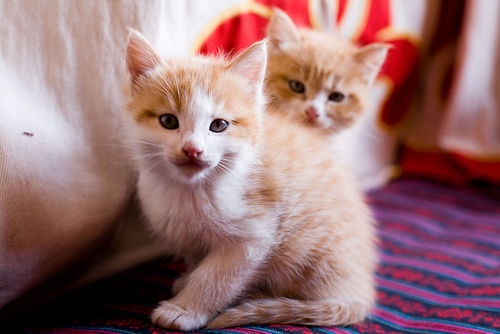

In [ ]:
from PIL import Image
test_img_path = './img/2007_000876.jpg'
test_img = Image.open(test_img_path)
test_img

**test image를 normalize한다**

In [ ]:
import torchvision.transforms as transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

test_transform = transform(test_img).cuda().unsqueeze(0)
print(test_transform.size())

torch.Size([1, 3, 224, 224])


**VGG-Net을 Load한다.**

In [ ]:
import torchvision.models.vgg as vgg
imageNet = vgg.vgg16(pretrained=True).cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 166MB/s]


In [ ]:
import torch
import torch.nn as nn
with torch.no_grad():
    out = imageNet(test_transform)

out_class = torch.argmax(out)
print(out.size())
print(out_class)

torch.Size([1, 1000])
tensor(285, device='cuda:0')


In [ ]:
# 적당하게 패딩해주자.
m = nn.ZeroPad2d((111,112,111,112))
pad_image = m(test_transform)
img_1by1 = torch.zeros((224,224)).cuda()

In [ ]:
# 픽셀 하나하나마다 연산을 진행한다.
# 이 셀은 시행이 완료되기까지 오랜 시간이 걸린다! 주의하자
for i in range(224):
    for j in range(224):
        patch = pad_image[:,:,i:i+224,j:j+224]
        # classify each pixels
        with torch.no_grad():
            img_1by1[i,j] = torch.argmax(imageNet(patch))

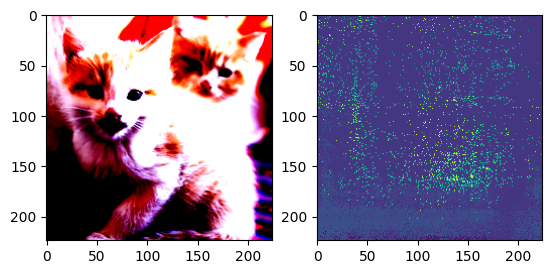

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(1,2,1)
plt.imshow(test_transform[0].data.cpu().numpy().transpose((1,2,0)))
plt.subplot(1,2,2)
plt.imshow(img_1by1.data.cpu().numpy())
plt.show()

**- 굉장히 비효율적이고, 학습이 잘 되지 않아 성능도 제대로 나오지 않은 것을 볼 수 있다.**

### section 2. Upsampling과 Downsampling을 사용하지 않고, 단순히 원래 Classification에 사용했던 모델에서 마지막 Layer만 Fully Connected Layer을 1x1의 Convolution 으로 대체하였을때

In [ ]:
import torchvision.models as models

class VGG_only_Convolution(nn.Module):
    def __init__(self):
        super(VGG_only_Convolution, self).__init__()
        self.features = models.vgg16(pretrained=True).features

        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7)

        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)

        # fc8
        self.fc8 = nn.Conv2d(4096, 1000, 1)

        # ReLU
        self.relu = nn.ReLU(inplace=True)

        # Dropout
        self.dropout = nn.Dropout2d()

        self.copy_params_from_vgg16()

    def forward(self, x):
        conv5 = self.features(x)

        fc6 = self.relu(self.fc6(conv5))
        fc7 = self.dropout(fc6)

        fc7 = self.relu(self.fc7(fc7))
        fc8 = self.dropout(fc7)

        score = self.fc8(fc8)

        return score

    def copy_params_from_vgg16(self):
        vgg16 = models.vgg16(pretrained=True)
        for i, name in zip([0, 3, 6], ['fc6', 'fc7', 'fc8']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data.copy_(l1.weight.data.view(l2.weight.size()))
            l2.bias.data.copy_(l1.bias.data.view(l2.bias.size()))

In [ ]:
vgg_only = VGG_only_Convolution().cuda()
vgg_only

VGG_only_Convolution(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padd

In [ ]:
transform_conv = transforms.Compose([
    transforms.ToTensor(),
    normalize,
])
test_conv = transform_conv(test_img).cuda().unsqueeze(0)
conv_out = vgg_only(test_conv)
pred = torch.argmax(conv_out, dim=1)
pred

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


tensor([[[277, 277, 277, 287, 287, 287, 283, 283, 283],
         [277, 277, 277, 287, 287, 283, 283, 283, 287],
         [277, 277, 277, 356, 287, 287, 283, 283, 287],
         [356, 356, 356, 356, 287, 287, 937, 287, 287]]], device='cuda:0')

**이 또한, 그다지 좋지 못한 성능을 보이며, 심지어 이미지 사이즈도 변경되었음을 알 수 있다.**

## section 3. Bilinear interpolation으로 Upsampling
- 마지막 layer에 bilinear interpolation을 추가
- bilinear interpolation은 Pytorch 라이브러리를 이용하면 간편하게 사용 가능
- bilinear interpolation을 이용하여 네트워크 출력을 입력 크기와 동일하게 만든다.

<img src="https://drive.google.com/uc?export=view&id=16gx2y7O3m-qfmZfotQQRbbafOLneZT4K" alt="no_image" style="width: 900px;"/>


In [ ]:
class bilinear_upsampled_VGG16(nn.Module):
    def __init__(self):
        super(bilinear_upsampled_VGG16, self).__init__()
        self.features = models.vgg16(pretrained=True).features
        self.features[0].padding = (100,100)  # 이미지 크기를 맞추기 위한 패딩 설정

        # fc6 layer
        self.fc6 = nn.Conv2d(512, 4096, 7)

        # fc7 layer
        self.fc7 = nn.Conv2d(4096, 4096, 1)

        # fc8 layer를 정의하고 PASCAL VOC class를 위해 출력 채널을 21로 설정합니다.
        self.fc8 = nn.Conv2d(4096, 21, 1)

        # ReLU
        self.relu = nn.ReLU(inplace=True)

        # Dropout
        self.dropout = nn.Dropout2d()


        # scaling factor 32이고, bilinear interpolation을 사용하는 upsample layer 계층을 정의합니다. scaling factor를 32로 설정한 이유는 아래에 적어두었습니다.
        self.upsample = nn.Upsample(scale_factor=32, mode='bilinear', align_corners=True)

        # pre-train된 VGG16 모델의 매개변수를 복사합니다.
        self.copy_params_from_vgg16()

    def forward(self, x):
        conv5 = self.features(x)  # 입력을 VGG16의 특징 추출 계층들을 통해 전달합니다.

        fc6 = self.relu(self.fc6(conv5))  # conv5의 출력을 fc6 계층을 통해 전달합니다.
        fc7 = self.dropout(fc6)   # fc6 출력에 드롭아웃을 적용합니다.

        score = self.fc8(fc7)  # fc7의 출력을 fc8 계층을 통해 전달합니다.

        input_size = x.size()[2:]  # 입력 크기(높이, 너비)를 저장합니다.
        upsampled_score = self.upsample(score)   # 이중 선형 업샘플링 계층을 추가합니다.

        # upsampled_score의 크기를 입력 크기와 일치하도록 조정합니다.
        upsampled_score = nn.functional.interpolate(upsampled_score, size=input_size, mode='bilinear', align_corners=True)
        return upsampled_score

    def copy_params_from_vgg16(self): # pre-train된 VGG16 모델의 매개변수를 복사하는 함수입니다. 조금 어려울 수 있으니 이해하지 않고 넘어가셔도 됩니다.
        vgg16 = models.vgg16(pretrained=True)
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data.copy_(l1.weight.data.view(l2.weight.size()))
            l2.bias.data.copy_(l1.bias.data.view(l2.bias.size()))

## bilinear interpolation 추가 설명

bilinear interpolation은 2차원 공간에서 주어진 점들 사이의 값을 추정하기 위한 선형 보간법의 확장이다. 주로 이미지 처리, 지리정보시스템(GIS), 컴퓨터 그래픽스 등에서 사용되며, 소스 이미지의 해상도를 높이거나 낮추는 과정에서 픽셀 값을 보간하는 데 유용하다.

bilinear interpolation을 통해, 주어진 점 (x, y)의 주변 4개 픽셀 값에 기반하여 새로운 픽셀 값을 추정할 수 있다. 이 방법은 고해상도로 확대한 이미지에서 부드러운 경계 처리와 안티앨리어싱(anti-aliasing) 효과를 제공하며, 비교적 빠른 계산 속도를 가지고 있다. 하지만, 매우 크게 확대할 경우 결과 이미지가 흐릿해질 수 있으며 선명도가 떨어지는 단점이 있다.

이 코드에서 Upsample 계층에서 scale_factor를 32로 설정하는 이유는 네트워크 출력을 입력 이미지의 원래 크기로 복원하기 위해서이다.

VGG16 아키텍처는 원본 이미지 크기를 줄이면서 특징을 추출한다. 특히, 네트워크를 통해 이미지를 전달할 때마다 여러 풀링 계층이 이미지 크기를 절반으로 줄인다. VGG16에서 5개의 풀링 계층이 있기 때문에 최종 특징 맵의 크기는 원래 입력 이미지 크기의 1/32이다.

따라서 원본 입력 이미지 크기로 결과를 복원하려면 스케일 팩터를 32로 설정해야 한다. 이렇게 하면 네트워크 출력을 원래 이미지 크기로 빠르게 복원할 수 있으며, 결과적으로 입력 이미지와 동일한 공간 해상도를 가진 세그멘테이션 마스크를 얻을 수 있다.

In [ ]:
bilinear_upsample = bilinear_upsampled_VGG16().cuda()
model_data = torch.load('./bilinear_upsampled_VGG16.pth')
bilinear_upsample.load_state_dict(model_data)

<All keys matched successfully>

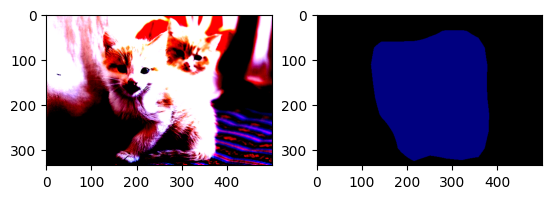

In [ ]:
with torch.no_grad():
    conv_out = bilinear_upsample(test_conv)
output = torch.argmax(conv_out, dim=1)

vis_output = functions.segmentation_output(output[0].data.cpu().numpy())

plt.subplot(1,2,1)
plt.imshow(test_conv[0].data.cpu().numpy().transpose((1,2,0)))
plt.subplot(1,2,2)
plt.imshow(vis_output)

### section 4. 인코더/디코더 구조의 CNN 모델

#### Transposed Convolution (디코더)

<img src="https://drive.google.com/uc?export=view&id=1O6DOA0txVouNBMjOsZQz8i_-3ksn57bm"  onerror="this.style.display='none'" /><br><br>


- Transposed Convolution("Deconvolution"이라고 함)은 학습 가능한 필터를 사용하여 입력 해상도를 디코딩(Upsampling)하는 데 사용됩니다. 공간 정보를 하나의 지점으로 압축하는 표준 Convolution과 달리 입력 지점을 여러 공간 위치에 분산시킵니다.
- 예를 들어 stride가 2인 3×3 Deconvolution 커널은 2×2(청록색 사각형) 입력을 5×5(파란색 사각형) 출력으로 변환합니다.




#### Dilated Convolution
<img src="https://drive.google.com/uc?export=view&id=1lbDUeAu-2TR8SqnsniooriD5OA0CoZl-"  onerror="this.style.display='none'" /><br><br>

- The dilated convolution은 일반 convolution에 'Dilation rate'을 적용한 것이다.

- The dilated convolution은 추가적인 매개변수 없이 필터가 커버하는 영역을 확대한다. Dilation rate은 확대하는 간격의 크기이다.

- 예를 들어, Dilation rate이 2인 3×3 커널은 5×5 커널과 동일한 receptive field(수용 영역)를 갖지만 여전히 9개의 매개변수만 사용하는 반면 5×5는 25개의 매개변수를 사용합니다.




### FCN8s model 구조

<img src="https://drive.google.com/uc?export=view&id=1b9GQsVlL6lecP54_lHTSbocyGHCf-g_g"  onerror="this.style.display='none'" /><br><br>

<p style='text-align:right;'>[<a href='https://medium.com/@wilburdes/semantic-segmentation-using-fully-convolutional-neural-networks-86e45336f99b'>source</a>]</p>

## 다음과 같은 구조로 모델이 형성된다.

- Predict 1: $1\times1$ Conv(in: 4096, out: n_class)
- Predict 2: $1\times1$ Conv(in: 512, out: n_class), weight = 0.01
- Predict 3: $1\times1$ Conv(in: 256, out: n_class), weight = 0.0001

- Deconv 1: $4\times4$ Transposed Conv (in: n_class, out: n_class, stride: 2, biase: False)
- Deconv 2: $4\times4$ Transposed Conv (in: n_class, out: n_class, stride: 2, biase: False)
- Deconv 3: $16\times16$ Transposed Conv (in: n_class, out: n_class, stride: 8, biase: False)

In [ ]:
class FCN8s(nn.Module):
    def __init__(self, n_class=21):
        super(FCN8s, self).__init__()
        # pre-train된 VGG weight들을 불러온다.
        self.features = models.vgg16(pretrained=True).features

        # fc6 layer
        self.fc6 = nn.Conv2d(512, 4096, 7)


        # fc6 layer
        self.fc7 = nn.Conv2d(4096, 4096, 1)


        # ReLU
        self.relu = nn.ReLU(inplace=True)

        # Dropout
        self.dropout = nn.Dropout2d()


        # 각 단계에 대한 prediction convolutions (Downsampling) 을 정의
        self.predict_conv1 = nn.Conv2d(4096, n_class, kernel_size=1)
        self.predict_conv2 = nn.Conv2d(512, n_class, kernel_size=1)
        self.predict_conv3 = nn.Conv2d(256, n_class, kernel_size=1)

        # Upscaling prediction (Upsampling)을 위한 Deconvolution layer를 정의
        self.deconv1 = nn.ConvTranspose2d(n_class, n_class, kernel_size=4, stride=2, bias=False)
        self.deconv2 = nn.ConvTranspose2d(n_class, n_class, kernel_size=4, stride=2, bias=False)
        self.deconv3 = nn.ConvTranspose2d(n_class, n_class, kernel_size=16, stride=8, bias=False)

        self._initialize_weights()
        self.copy_params_from_vgg16()

    def _initialize_weights(self):
        self.features[0].padding = (100,100)

        # MaxPool2d layer와 ConvTranspose2d layer의 초기화. 이해가 어려우면 넘어가셔도 좋습니다.
        for m in self.modules():
            if isinstance(m, nn.MaxPool2d):
                m.ceil_mode = True
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = functions.get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)

    def forward(self, x):
        initial = x
        # VGG 네트워크를 통과시키고, pool3와 pool4의 결과를 저장한다.
        for idx, layer in enumerate(self.features):
            x = layer(x)
            if idx == 16:
                pool3 = x.clone()
            elif idx == 23:
                pool4 = x.clone()

        # Pass through fc6 layer
        x = self.dropout(self.relu(self.fc6(x)))

        # Pass through fc7 layer
        x = self.dropout(self.relu(self.fc7(x)))

        # Pass through Prediction 1 and Deconvolution 1
        x = self.predict_conv1(x)
        x = self.deconv1(x)
        deconv1 = x

        # Pass through Prediction 2
        x = self.predict_conv2(pool4)
        x = x[:, :, 5:5 + deconv1.size(2), 5:5 + deconv1.size(3)] # Crop boundary
        predict2 = x

        # Add deconv1 and predict2, then pass through Deconvolution 2
        x = deconv1 + predict2 * 0.01
        x = self.deconv2(x)
        deconv2 = x

        # Pass through Prediction 3
        x = self.predict_conv3(pool3)
        x = x[:, :, 9:9 + deconv2.size(2), 9:9 + deconv2.size(3)] # Crop boundary
        predict3 = x

        # Add predict3 and deconv2
        x = predict3 * 0.0001 + deconv2

        # Pass through Deconvolution 3
        x = self.deconv3(x)
        x = x[:, :, 31:31+initial.size(2), 31:31+initial.size(3)].contiguous() # Crop boundary
        return x

    def copy_params_from_vgg16(self): # pre-train된 VGG16 모델의 매개변수를 복사하는 함수입니다. 조금 어려울 수 있으니 이해하지 않고 넘어가셔도 됩니다.
        vgg16 = models.vgg16(pretrained=True)
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data.copy_(l1.weight.data.view(l2.weight.size()))
            l2.bias.data.copy_(l1.bias.data.view(l2.bias.size()))

## FCN8 (Fully Convolutional Network with 8-stride)

FCN8 (Fully Convolutional Network with 8-stride)는 세멘틱 분할(Semantic Segmentation)을 수행하기 위한 딥러닝 아키텍처입니다. 세멘틱 분할은 이미지의 각 픽셀에 레이블을 할당하는 작업으로, 객체 인식 및 분류와 달리 이미지에서 객체의 정확한 위치와 경계를 파악할 수 있게 해줍니다.

FCN8은 기존의 VGG16 네트워크를 기반으로 구축되었으며, 기존의 전연결 계층(Fully Connected Layers)를 컨볼루션 계층(Convolutional Layers)으로 바꾸어 공간 정보를 유지하면서 특징 추출이 가능하게 합니다. 이러한 변형을 통해 FCN은 입력 이미지의 크기에 관계없이 동작할 수 있습니다.

FCN8의 주요 특징은 다음과 같습니다:

스킵 커넥션(Skip Connections): FCN8은 여러 해상도의 특징 맵을 결합하여 세부 정보와 전체적인 구조 정보를 모두 활용합니다. 이를 위해 풀링 계층(pool3, pool4)에서 추출한 특징 맵과 최종 컨볼루션 계층에서 얻은 특징 맵을 결합합니다. 이를 통해 높은 수준의 추상화와 높은 해상도의 세부 정보를 동시에 활용할 수 있습니다.

업샘플링(Up-sampling): FCN8은 세 개의 디컨볼루션(Deconvolution) 계층을 사용하여 특징 맵을 원본 이미지 크기로 업샘플링합니다. 이를 통해 각 픽셀에 대한 예측이 가능하게 됩니다.

FCN8의 동작 과정은 다음과 같습니다:

VGG16의 컨볼루션 계층을 사용하여 이미지에서 특징을 추출합니다.
전연결 계층 대신 컨볼루션 계층을 사용하여 공간 정보를 유지하면서 특징을 처리합니다.
스킵 커넥션을 사용하여 여러 해상도의 특징 맵을 결합합니다.
디컨볼루션 계층을 사용하여 원본 이미지 크기로 업샘플링합니다.
최종 예측을 생성하고, 각 픽셀에 레이블을 할당합니다.
FCN8은 세멘틱 분할 작업에서 높은 성능을 보여주며, 다양한 환경에서 객체의 정확한 위치와 경계를 파악할 수 있습니다. 이러한 이유로 FCN8은 이미지 분할, 객체 인식, 자율주행차 등 다양한 분야에서 사용되고 있습니다.

FCN8의 단점 중 하나는 속도입니다. 디컨볼루션 연산이 복잡하고, 스킵 커넥션을 통한 특징 맵 결합 과정이 연산량을 증가시키기 때문입니다. 이러한 문제를 해결하기 위해 다양한 연구가 진행되고 있으며, 이를 바탕으로 개선된 네트워크 구조와 효율적인 연산 방법이 제안되고 있습니다.

이 아래의 Data load 셀은 수정하거나 코드 추가 없이 그냥 실행해주시면 됩니다.

**Data load**

In [ ]:
img_list = functions.read_file('./list/train_aug.txt')
data_list = []

for i in range(10):
    np.random.shuffle(img_list)
    data_list.extend(img_list)
data_gen = functions.chunker(data_list, 1)

In [ ]:
model = FCN8s().cuda()

# section 5.

적절한 learning rate와 max_iter(epoch)를 설정하여 FCN 모델을 학습시켜보자. 우리의 목표는 다음과 같다.

(1) mIoU는 bilinear interpolation만을 사용한 모델보다 높아야 한다.

(2) 또한, FCN-8의 mIoU는 0.45를 넘겨야 한다.

In [ ]:
lr = 0.00001

optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer.zero_grad()
criterion = nn.CrossEntropyLoss() # cross-entropy loss 함수 사용
max_iter = 30000


- cross-entropy loss를 사용합니다.
- 100 iterations 마다 training loss를 출력합니다.
- training loss가 점진적으로 감소하는 것을 관찰해보세요.

In [ ]:
running_loss = 0.0
for iter in range(max_iter + 1):
    inputs, label = functions.get_data(next(data_gen))
    # training loop
    model.train()
    inputs = torch.tensor(inputs).cuda()
    label = torch.tensor(label).long().cuda()

    optimizer.zero_grad()

    output = model(inputs)
    loss = criterion(output, label)

    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if (iter % 100 == 0) & (iter != 0):
        print(f'Iteration: {iter}, Loss: {running_loss / (iter+1)}')

<ipython-input-22-102bcb7e3674>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs).cuda()
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Iteration: 100, Loss: 2.9636725845313308
Iteration: 200, Loss: 2.3625223884238533
Iteration: 300, Loss: 2.0945479102506988
Iteration: 400, Loss: 1.9135958895161562
Iteration: 500, Loss: 1.8011766438801846
Iteration: 600, Loss: 1.7243197823993974
Iteration: 700, Loss: 1.6496763714667564
Iteration: 800, Loss: 1.600276851242922
Iteration: 900, Loss: 1.5599593926018536
Iteration: 1000, Loss: 1.5169583700902456
Iteration: 1100, Loss: 1.4791356443709183
Iteration: 1200, Loss: 1.4563630633893656
Iteration: 1300, Loss: 1.4320056486780326
Iteration: 1400, Loss: 1.4110362547304187
Iteration: 1500, Loss: 1.3869749203641997
Iteration: 1600, Loss: 1.3628683321010426
Iteration: 1700, Loss: 1.3459638913568857
Iteration: 1800, Loss: 1.3309487379768834
Iteration: 1900, Loss: 1.316395417941457
Iteration: 2000, Loss: 1.2964481707496651
Iteration: 2100, Loss: 1.2741192913020667
Iteration: 2200, Loss: 1.2592763174062884
Iteration: 2300, Loss: 1.2471661939431808
Iteration: 2400, Loss: 1.2329105176473782
Ite

### section 6. 결과 관찰
- 아래의 'validation_miou' 함수를 이용하여 우리가 만든 FCN 모델이 bilinear interpolation 만을 사용한 모델 만큼의 성능이 나오는지 확인해보자.
- network의 output을 보기 위해 위에서 정의한 'segmentation_output' 함수를 이용할 것이다.

**아래의 코드는 추가로 입력할 필요 없이 실행만 해주시면 됩니다.**

In [ ]:
fcn8s_miou = functions.validation_miou(model)
bilinearVgg_miou = functions.validation_miou(bilinear_upsample)

mIoU 계산 시작!
mIoU =  0.49126208546254546
mIoU 계산 시작!
mIoU =  0.43856789417745157


In [ ]:
print('FCN-8의 mIoU =', fcn8s_miou)
print('bilinear로 upsample된 모델의 mIoU =', bilinearVgg_miou)

FCN-8의 mIoU = 0.49126208546254546
bilinear로 upsample된 모델의 mIoU = 0.43856789417745157


# *** FCN8의 mIoU가 bilinear upsampled VGG-16의 mIoU보다 높게 측정되면, 실습에 성공한 것이다!!***

## Discussion :
FCN8의 mIoU가 더 높게 나왔으며, 따라서 성능이 Bilinear Interpolation에 비해 더 좋은 것을 확인 할 수 있었다. 그러나 FCN8을 학습시키는 데 꽤 많은 시간과 컴퓨터 자원(메모리 등)이 필요했으며 연산에 더 오랜 시간이 걸렸다. 따라서 정확한 Semantic Segmentation을 위해서는 FCN8을 충분히 이용할 가치가 있지만, 간단하고 빠른 계산을 위해선 Bilinear Interpolation이 적절하게 이용될 수도 있다. 많은 논문들이 CNN 모듈과 Bilinear Interpolation을 적절히 섞어서 사용한다.

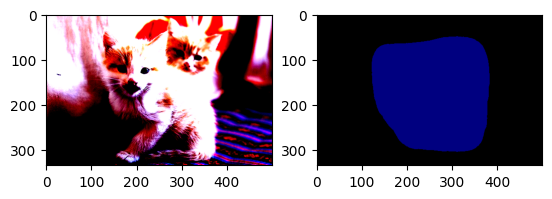

In [ ]:
# Visualize the result
with torch.no_grad():
    conv_out_model = model(test_conv)
output_model = torch.argmax(conv_out_model, dim=1)

vis_output_model = functions.segmentation_output(output_model[0].data.cpu().numpy())

plt.subplot(1,2,1)
plt.imshow(test_conv[0].data.cpu().numpy().transpose((1,2,0)))
plt.subplot(1,2,2)
plt.imshow(vis_output_model)

### *References*
FCN official code (https://github.com/shelhamer/fcn.berkeleyvision.org)

Upsampling method (https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d)

Cs231n (http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture11.pdf)